In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import OneHotEncoder
import numpy as np

import matplotlib.pyplot as plt

import pandas as pd

In [2]:
tf.__version__

'2.7.0'

In [3]:
keras.__version__

'2.7.0'

In [4]:
def plot_metric(history, metric):
    
    train_metrics = history.history[metric]
    val_metrics = history.history['val_' + metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation ' + metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric)
    plt.legend(['train_' + metric, 'val_' + metric])
    plt.show()
    
    return None

In [5]:
def fit_embbeding(training_data, downstream_task, categorical_feature, target, embedding_size, hidden_units):
    
    training_data, vocab = generate_one_hot_data(training_data, categorical_feature)
    neural_network, df_embeddings = build_neural_network(downstream_task, training_data, categorical_feature, vocab, target, 
                                                         embedding_size, hidden_units)
    
    return df_embeddings

In [6]:
def generate_one_hot_data(training_data, categorical_feature):
    
    encoder = OneHotEncoder(handle_unknown='ignore')
    categorical_data = np.array(training_data[categorical_feature]).reshape(-1, 1)
    encoder.fit(categorical_data)
    embeddings_array = encoder.transform(categorical_data).toarray()
    vocab = [item for sublist in list(encoder.categories_) for item in sublist]
#     vocab = encoder.categories_[0]
    
    training_data = pd.merge(training_data, 
                              pd.DataFrame(embeddings_array, columns = vocab), 
                              how = 'left', 
                              left_index = True, 
                              right_index = True)
    
    return training_data, vocab

In [7]:
def build_neural_network(downstream_task, training_data, categorical_feature, vocab, target, embedding_size, hidden_units):
    
    num_oov_buckets = 0
    num_cats = len(vocab)

    categorical_input_layer = keras.Input(shape=(num_cats, ), name='categorical_input_layer')

    embedded = keras.layers.Embedding(num_cats + num_oov_buckets, 
                                      embedding_size, 
                                      input_length=1, name='embedding')(categorical_input_layer)

    # Concatenate the embeddings (and remove the useless extra dimension)
    concatenated = keras.layers.Concatenate()([embedded])

    out = keras.layers.Flatten()(concatenated)

    # Add one or more hidden layers
    for n_hidden in hidden_units:
        out = keras.layers.Dense(n_hidden, activation='relu')(out)

    if downstream_task == 'regression':
        out = keras.layers.Dense(1, activation='linear', name='prediction')(out)
        loss = 'MSE'
        metrics = ['MAE']
        
    else: # binary classification:
        out = keras.layers.Dense(1, activation='sigmoid', name='prediction')(out)
        loss = 'binary_crossentropy'
        metrics = ['accuracy']
    
    neural_network = keras.Model(inputs = [categorical_input_layer], outputs = out,)
#     neural_network.summary(line_length = 88)

    neural_network.compile(keras.optimizers.Adam(), loss = loss, metrics = metrics,)
    
    early_stopping = EarlyStopping(patience = 20)
    
    history = neural_network.fit(
                                training_data[vocab],
                                training_data[target],
                                batch_size = 30,
                                epochs = 300,
                                verbose = True, # Or False if you will
                                validation_split = .3,
                                callbacks = [early_stopping]);
    
    plot_metric(history, metrics[0])
    
#     preds = model.predict([training_data[vocab]])
    
    embeddings = neural_network.layers[1].get_weights()[0]
    
    df_embeddings = pd.DataFrame(embeddings, vocab).add_prefix('Emb_')
    df_embeddings = df_embeddings.reset_index()
    
    return neural_network, df_embeddings

In [8]:
def merge_embeddings(data, lookup_table, categorical_feature):
    
    data = pd.merge(data, lookup_table, how = 'left', left_on = categorical_feature, right_on = 'index')
    data = data.drop('index', axis=1)
    
    return data

# Data

In [9]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [10]:
fetch_housing_data()

In [11]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [22]:
df = load_housing_data()

In [23]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [24]:
df['ocean_proximity'].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

# Embeddings

Epoch 1/300
482/482 [==============================] - 1s 1ms/step - loss: 51960107008.0000 - MAE: 198431.6250 - val_loss: 65354076160.0000 - val_MAE: 225544.4375
Epoch 2/300
482/482 [==============================] - 1s 1ms/step - loss: 50411679744.0000 - MAE: 194460.6875 - val_loss: 61083250688.0000 - val_MAE: 215869.1094
Epoch 3/300
482/482 [==============================] - 1s 1ms/step - loss: 42875506688.0000 - MAE: 173803.2969 - val_loss: 47505215488.0000 - val_MAE: 181767.4219
Epoch 4/300
482/482 [==============================] - 1s 1ms/step - loss: 28497760256.0000 - MAE: 127930.6094 - val_loss: 28790632448.0000 - val_MAE: 129135.8438
Epoch 5/300
482/482 [==============================] - 1s 1ms/step - loss: 16413478912.0000 - MAE: 90254.3984 - val_loss: 17852760064.0000 - val_MAE: 100270.4219
Epoch 6/300
482/482 [==============================] - 1s 1ms/step - loss: 12852931584.0000 - MAE: 84841.7969 - val_loss: 15501496320.0000 - val_MAE: 96384.3906
Epoch 7/300
482/482 [====

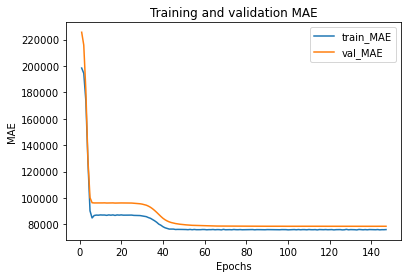

Wall time: 1min 28s


In [25]:
%%time

training_data = df
downstream_task = 'regression'
categorical_feature = 'ocean_proximity'
target = 'median_house_value'
embedding_size = 2
hidden_units = (50, 10)

df_embeddings = fit_embbeding(training_data, downstream_task, categorical_feature, target, embedding_size, hidden_units)

In [26]:
df = merge_embeddings(df, df_embeddings, categorical_feature)

# Downstream Task

In [27]:
from sklearn.linear_model import LinearRegression

In [40]:
one_hot_data, vocab = generate_one_hot_data(df, categorical_feature)

one_hot_data = one_hot_data.dropna()

X = one_hot_data[vocab + ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].copy()
y = one_hot_data['median_house_value']

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.6422908026153932

In [41]:
df = df.dropna()

X = df[['Emb_0', 'Emb_1'] + ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income']].copy()
y = df['median_house_value']

reg = LinearRegression().fit(X, y)
reg.score(X, y)

0.645820821574624